<a href="https://colab.research.google.com/github/muhdlaziem/DR/blob/master/DenseNet(3_classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/'My Drive'/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [ ]:
%tensorflow_version 1.x

In [ ]:
nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)
print(tf.__version__)

1.15.2


In [ ]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
# Image size
im_size = 320
# Batch size
BATCH_SIZE = 20

# Loading

In [ ]:
%cd diabetic-retinopathy-resized/
DR = pd.read_csv('5_3_2_levels.csv')
DR.head()

/gdrive/My Drive/diabetic-retinopathy-resized


,image,level,level(3),level(2)
0,10_left.jpeg,0,0,0
1,10_right.jpeg,0,0,0
2,13_left.jpeg,0,0,0
3,13_right.jpeg,0,0,0
4,15_left.jpeg,1,1,1


In [ ]:
DR['level(3)'].value_counts()

0    25802
1     7726
2     1580
Name: level(3), dtype: int64

## Under Sampling

In [ ]:
index_0 = DR[DR['level(3)']==0].sample(25802-1600).index
index_1 = DR[DR['level(3)']==1].sample(7726-1599).index
index_2 = DR[DR['level(3)']==2].sample(1580-1580).index

undersampling_DR = DR.drop(index_0)
undersampling_DR = undersampling_DR.drop(index_1)
undersampling_DR = undersampling_DR.drop(index_2)

undersampling_DR['level(3)'].value_counts()

0    1600
1    1599
2    1580
Name: level(3), dtype: int64

## Train - Valid split

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(undersampling_DR,test_size=0.30, random_state=42)

In [ ]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(3345, 4)
(1434, 4)


## Process Images

Crop function: https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping 

In [ ]:
def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

/gdrive/My Drive/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped


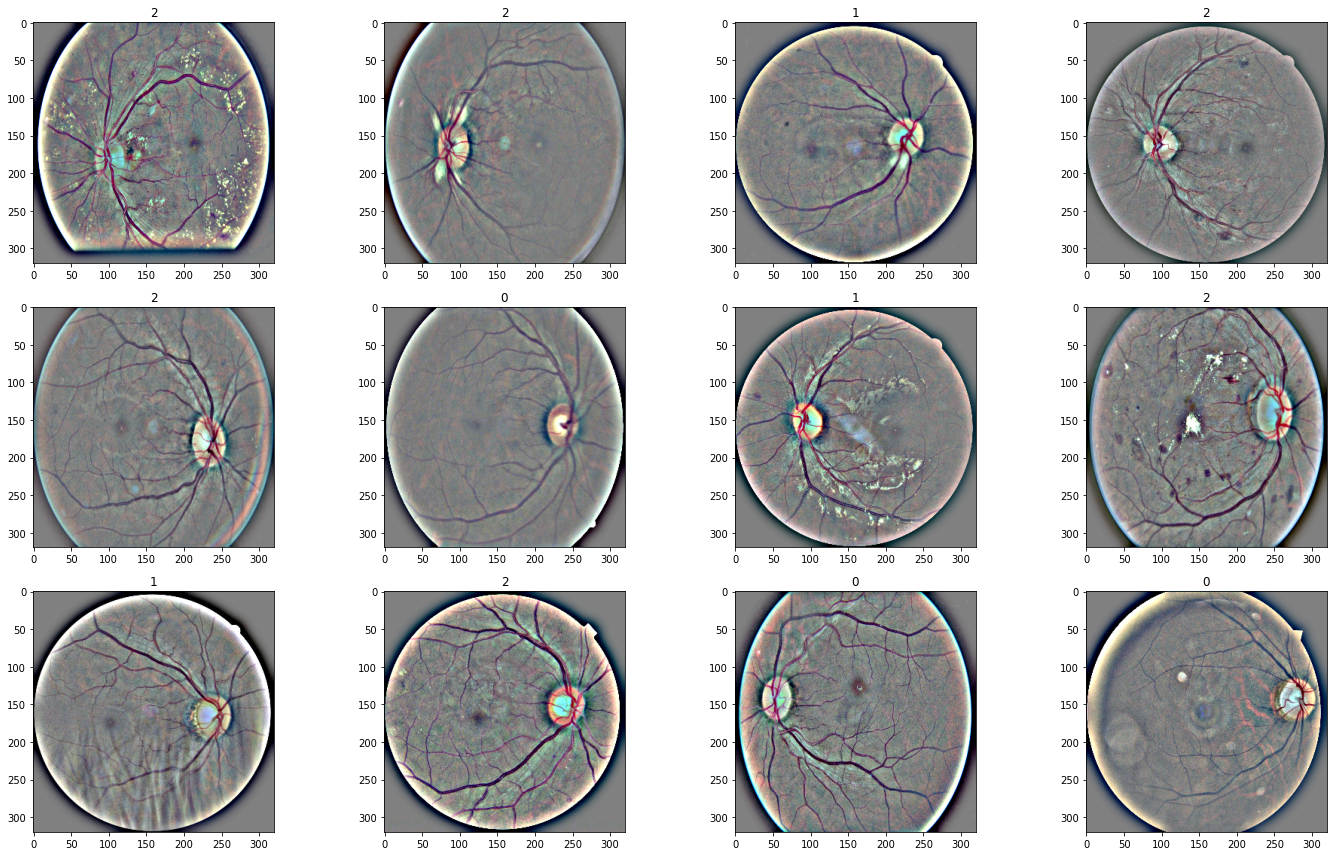

In [ ]:
%cd /gdrive/My Drive/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'image']
        image_id = df.loc[i,'level(3)']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Processing Images

__UPDATE:__ Here we are reading just the validation set. In order to use 320x320 images, we are going to load one bucket at a time only when needed. This will let our code run without memory-related errors.

In [ ]:
# validation set
N = val_df.shape[0]
x_val = np.empty((N, im_size, im_size, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['image'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

In [ ]:
y_train = pd.get_dummies(train_df['level(3)']).values
y_val = pd.get_dummies(val_df['level(3)']).values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(3345, 3)
(1434, 320, 320, 3)
(1434, 3)


# Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 2] = y_train[:, 2]

for i in range(1, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_val_multi[:, 2] = y_val[:, 2]

for i in range(1, -1, -1):
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

print("Y_train multi: {}".format(y_train_multi.shape))
print("Y_val multi: {}".format(y_val_multi.shape))

Y_train multi: (3345, 3)
Y_val multi: (1434, 3)


In [ ]:
y_train = y_train_multi
y_val = y_val_multi

# Creating keras callback for QWK

---

I had to change this function, in order to consider the best kappa score among all the buckets.

In [ ]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('denseNet.h5')

        return

# Data Generator

In [ ]:
def create_datagen():
    return ImageDataGenerator(
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 360
    )

# Model: DenseNet-121

In [ ]:
densenet = DenseNet121(
    weights='/gdrive/My Drive/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(im_size,im_size,3)
)

In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0001,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluation

In [ ]:
#train_df = train_df.reset_index(drop=True)
bucket_num = 8
# bucket_num = 3
div = round(train_df.shape[0]/bucket_num)

In [ ]:
df_init = {
    'val_loss': [0.0],
    'val_accuracy': [0.0],
    'loss': [0.0], 
    'accuracy': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

In [ ]:
# I found that changing the nr. of epochs for each bucket helped in terms of performances
epochs = [5,5,10,15,15,20,20,30]
# epochs = [5,5,10]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

In [ ]:
for i in range(0,bucket_num):
    if i != (bucket_num-1):
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', desired_size = im_size)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div,:], batch_size=BATCH_SIZE)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', desired_size = im_size)
        data_generator = create_datagen().flow(x_train, y_train[i*div:,:], batch_size=BATCH_SIZE)
        
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)
    
    del data_generator
    del x_train
    gc.collect()
    
    print('-'*40)

Bucket Nr: 0



Epoch 1/5
21/20 [==============================] - 78s 4s/step - loss: 0.8793 - accuracy: 0.5000 - val_loss: 0.8784 - val_accuracy: 0.4670
val_kappa: 0.1398
Validation Kappa has improved. Saving model.
Epoch 2/5
21/20 [==============================] - 46s 2s/step - loss: 0.5543 - accuracy: 0.7113 - val_loss: 1.0036 - val_accuracy: 0.4570
val_kappa: 0.1252
Epoch 3/5
21/20 [==============================] - 46s 2s/step - loss: 0.4106 - accuracy: 0.8094 - val_loss: 0.9710 - val_accuracy: 0.4568
val_kappa: 0.1408
Validation Kappa has improved. Saving model.
Epoch 4/5
21/20 [==============================] - 46s 2s/step - loss: 0.3593 - accuracy: 0.8325 - val_loss: 0.7489 - val_accuracy: 0.5481
val_kappa: 0.3134
Validation Kappa has improved. Saving model.
Epoch 5/5
21/20 [==============================] - 46s 2s/step - loss: 0.3256 - accuracy: 0.8573 - val_loss: 0.5830 - val_accuracy: 0.6351
val_kappa: 0.4305
Validation Kappa has improved. Saving model.
----------------------------------


Epoch 1/5
21/20 [==============================] - 46s 2s/step - loss: 0.3339 - accuracy: 0.8501 - val_loss: 0.5279 - val_accuracy: 0.6718
val_kappa: 0.5009
Validation Kappa has improved. Saving model.
Epoch 2/5
21/20 [==============================] - 46s 2s/step - loss: 0.3096 - accuracy: 0.8636 - val_loss: 0.4196 - val_accuracy: 0.8298
val_kappa: 0.6581
Validation Kappa has improved. Saving model.
Epoch 3/5
21/20 [==============================] - 46s 2s/step - loss: 0.3052 - accuracy: 0.8708 - val_loss: 0.4180 - val_accuracy: 0.8371
val_kappa: 0.5926
Epoch 4/5
21/20 [==============================] - 46s 2s/step - loss: 0.2572 - accuracy: 0.8868 - val_loss: 0.4428 - val_accuracy: 0.7987
val_kappa: 0.4553
Epoch 5/5
21/20 [==============================] - 45s 2s/step - loss: 0.2640 - accuracy: 0.8907 - val_loss: 0.3843 - val_accuracy: 0.8261
val_kappa: 0.5629
----------------------------------------
Bucket Nr: 2



Epoch 1/10
21/20 [==============================] - 46s 2s/step - loss: 0.3156 - accuracy: 0.8644 - val_loss: 0.2758 - val_accuracy: 0.8819
val_kappa: 0.7118
Validation Kappa has improved. Saving model.
Epoch 2/10
21/20 [==============================] - 46s 2s/step - loss: 0.3152 - accuracy: 0.8517 - val_loss: 0.3265 - val_accuracy: 0.8498
val_kappa: 0.5845
Epoch 3/10
21/20 [==============================] - 45s 2s/step - loss: 0.2885 - accuracy: 0.8636 - val_loss: 0.3429 - val_accuracy: 0.8517
val_kappa: 0.5946
Epoch 4/10
21/20 [==============================] - 46s 2s/step - loss: 0.2805 - accuracy: 0.8820 - val_loss: 0.2803 - val_accuracy: 0.8708
val_kappa: 0.6895
Epoch 5/10
21/20 [==============================] - 45s 2s/step - loss: 0.2345 - accuracy: 0.9027 - val_loss: 0.2563 - val_accuracy: 0.8856
val_kappa: 0.7240
Validation Kappa has improved. Saving model.
Epoch 6/10
21/20 [==============================] - 46s 2s/step - loss: 0.2268 - accuracy: 0.8963 - val_loss: 0.2734 - 


Epoch 1/15
21/20 [==============================] - 46s 2s/step - loss: 0.3113 - accuracy: 0.8700 - val_loss: 0.3244 - val_accuracy: 0.8617
val_kappa: 0.6599
Epoch 2/15
21/20 [==============================] - 45s 2s/step - loss: 0.2824 - accuracy: 0.8748 - val_loss: 0.4071 - val_accuracy: 0.8312
val_kappa: 0.5720
Epoch 3/15
21/20 [==============================] - 45s 2s/step - loss: 0.2433 - accuracy: 0.8836 - val_loss: 0.4169 - val_accuracy: 0.8364
val_kappa: 0.5766
Epoch 4/15
21/20 [==============================] - 45s 2s/step - loss: 0.2174 - accuracy: 0.8987 - val_loss: 0.4723 - val_accuracy: 0.8231
val_kappa: 0.5444
Epoch 5/15
21/20 [==============================] - 45s 2s/step - loss: 0.2272 - accuracy: 0.9003 - val_loss: 0.5792 - val_accuracy: 0.8040
val_kappa: 0.4805
Epoch 6/15
21/20 [==============================] - 45s 2s/step - loss: 0.2012 - accuracy: 0.9115 - val_loss: 0.5282 - val_accuracy: 0.8192
val_kappa: 0.5292
Epoch 7/15
21/20 [==============================] -


Epoch 1/15
21/20 [==============================] - 46s 2s/step - loss: 0.3881 - accuracy: 0.8501 - val_loss: 0.3871 - val_accuracy: 0.8642
val_kappa: 0.6526
Epoch 2/15
21/20 [==============================] - 45s 2s/step - loss: 0.2872 - accuracy: 0.8596 - val_loss: 0.3369 - val_accuracy: 0.8740
val_kappa: 0.6878
Epoch 3/15
21/20 [==============================] - 45s 2s/step - loss: 0.2769 - accuracy: 0.8780 - val_loss: 0.2910 - val_accuracy: 0.8877
val_kappa: 0.7204
Epoch 4/15
21/20 [==============================] - 45s 2s/step - loss: 0.2198 - accuracy: 0.9043 - val_loss: 0.2748 - val_accuracy: 0.8845
val_kappa: 0.7092
Epoch 5/15
21/20 [==============================] - 45s 2s/step - loss: 0.2139 - accuracy: 0.9091 - val_loss: 0.2648 - val_accuracy: 0.8835
val_kappa: 0.7045
Epoch 6/15
21/20 [==============================] - 45s 2s/step - loss: 0.1893 - accuracy: 0.9155 - val_loss: 0.2738 - val_accuracy: 0.8698
val_kappa: 0.6577
Epoch 7/15
21/20 [==============================] -


Epoch 1/20
21/20 [==============================] - 46s 2s/step - loss: 0.3482 - accuracy: 0.8716 - val_loss: 0.8064 - val_accuracy: 0.8031
val_kappa: 0.4594
Epoch 2/20
21/20 [==============================] - 45s 2s/step - loss: 0.2735 - accuracy: 0.8796 - val_loss: 0.8682 - val_accuracy: 0.7773
val_kappa: 0.3964
Epoch 3/20
21/20 [==============================] - 45s 2s/step - loss: 0.2558 - accuracy: 0.8836 - val_loss: 0.7801 - val_accuracy: 0.7813
val_kappa: 0.4109
Epoch 4/20
21/20 [==============================] - 46s 2s/step - loss: 0.2146 - accuracy: 0.9011 - val_loss: 0.4142 - val_accuracy: 0.8550
val_kappa: 0.6363
Epoch 5/20
21/20 [==============================] - 45s 2s/step - loss: 0.2267 - accuracy: 0.9035 - val_loss: 0.3232 - val_accuracy: 0.8782
val_kappa: 0.7010
Epoch 6/20
21/20 [==============================] - 45s 2s/step - loss: 0.1886 - accuracy: 0.9163 - val_loss: 0.4599 - val_accuracy: 0.8238
val_kappa: 0.5360
Epoch 7/20
21/20 [==============================] -


Epoch 1/20
21/20 [==============================] - 46s 2s/step - loss: 0.3694 - accuracy: 0.8573 - val_loss: 0.9256 - val_accuracy: 0.7564
val_kappa: 0.3071
Epoch 2/20
21/20 [==============================] - 46s 2s/step - loss: 0.2838 - accuracy: 0.8900 - val_loss: 0.6357 - val_accuracy: 0.8298
val_kappa: 0.5718
Epoch 3/20
21/20 [==============================] - 45s 2s/step - loss: 0.2028 - accuracy: 0.9019 - val_loss: 0.4848 - val_accuracy: 0.8501
val_kappa: 0.6250
Epoch 4/20
21/20 [==============================] - 45s 2s/step - loss: 0.1834 - accuracy: 0.9226 - val_loss: 0.3643 - val_accuracy: 0.8759
val_kappa: 0.7055
Epoch 5/20
21/20 [==============================] - 45s 2s/step - loss: 0.1658 - accuracy: 0.9306 - val_loss: 0.3392 - val_accuracy: 0.8838
val_kappa: 0.7259
Validation Kappa has improved. Saving model.
Epoch 6/20
21/20 [==============================] - 45s 2s/step - loss: 0.1756 - accuracy: 0.9234 - val_loss: 0.3792 - val_accuracy: 0.8624
val_kappa: 0.6555
Epoch 


Epoch 1/30
21/20 [==============================] - 51s 2s/step - loss: 0.3910 - accuracy: 0.8648 - val_loss: 0.6008 - val_accuracy: 0.8024
val_kappa: 0.2710
Epoch 2/30
21/20 [==============================] - 47s 2s/step - loss: 0.2629 - accuracy: 0.8934 - val_loss: 0.4877 - val_accuracy: 0.8357
val_kappa: 0.4628
Epoch 3/30
21/20 [==============================] - 46s 2s/step - loss: 0.2022 - accuracy: 0.9069 - val_loss: 0.3910 - val_accuracy: 0.8517
val_kappa: 0.5577
Epoch 4/30
21/20 [==============================] - 45s 2s/step - loss: 0.1822 - accuracy: 0.9181 - val_loss: 0.4216 - val_accuracy: 0.8391
val_kappa: 0.4907
Epoch 5/30
21/20 [==============================] - 45s 2s/step - loss: 0.1544 - accuracy: 0.9340 - val_loss: 0.3600 - val_accuracy: 0.8612
val_kappa: 0.6030
Epoch 6/30
21/20 [==============================] - 45s 2s/step - loss: 0.1457 - accuracy: 0.9372 - val_loss: 0.3136 - val_accuracy: 0.8663
val_kappa: 0.6186
Epoch 7/30
21/20 [==============================] -

In [ ]:
results = results.iloc[1:]
results['kappa'] = kappa_metrics.val_kappas
results = results.reset_index()
results = results.rename(index=str, columns={"index": "epoch"})
results

,epoch,val_loss,val_accuracy,loss,accuracy,bucket,kappa
0,0,0.878404,0.466992,0.879136,0.500000,0.0,0.139775
1,1,1.003624,0.456997,0.554149,0.711324,0.0,0.125215
2,2,0.970951,0.456764,0.410781,0.809410,0.0,0.140757
3,3,0.748871,0.548117,0.359696,0.832536,0.0,0.313382
4,4,0.583003,0.635054,0.325933,0.857257,0.0,0.430473
...,...,...,...,...,...,...,...
115,25,0.451471,0.868898,0.035895,0.988067,7.0,0.674111
116,26,0.407385,0.884007,0.031956,0.992045,7.0,0.709921
117,27,0.529019,0.871455,0.028672,0.989658,7.0,0.687636
118,28,0.537299,0.865412,0.030769,0.992840,7.0,0.626513


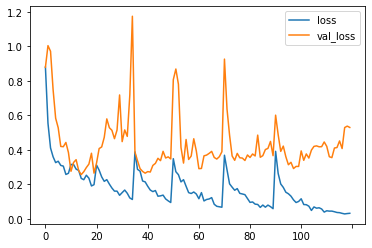

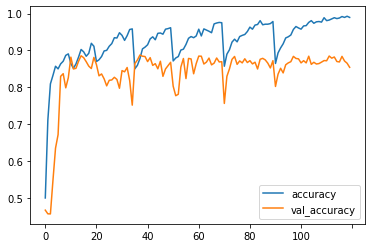

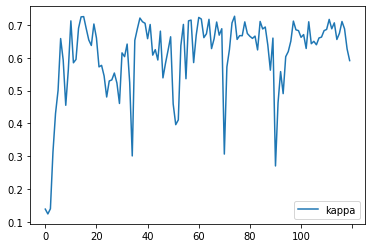

In [ ]:
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()
results[['kappa']].plot()
results.to_csv('results.csv',index=False)

# Find best threshold

In [ ]:
model.load_weights('denseNet.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

y1 = y_val_pred > best_threshold
y1 = y1.astype(int).sum(axis=1) - 1
y2 = y_val.sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Threshold: {}'.format(best_threshold))
print('Validation QWK score with best_threshold: {}'.format(score))

y1 = y_val_pred > .5
y1 = y1.astype(int).sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Validation QWK score with .5 threshold: {}'.format(score))

Threshold: 0.23749999999999977
Validation QWK score with best_threshold: 0.7514823663394526
Validation QWK score with .5 threshold: 0.7258874402733142


In [ ]:
%mv denseNet.h5 results.csv ../

In [ ]:
y_best = y_val_pred > best_threshold
y_best  = y_best .astype(int).sum(axis=1) - 1
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_best, y2))
print('Classification Report')
target_names = ['No DR', 'Moderate', 'Severe']
print(classification_report(y_best, y2, target_names=target_names))

Confusion Matrix
[[388 189  10]
 [ 96 205  77]
 [  9  66 394]]
Classification Report
              precision    recall  f1-score   support

       No DR       0.79      0.66      0.72       587
        Mild       0.45      0.54      0.49       378
      Severe       0.82      0.84      0.83       469

    accuracy                           0.69      1434
   macro avg       0.68      0.68      0.68      1434
weighted avg       0.71      0.69      0.69      1434



In [ ]:
# score = model.evaluate(x_val, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Inference Kernel

https://www.kaggle.com/raimonds1993/aptos19-densenet-trained-with-old-and-new-data


In [ ]:
print(tf.__version__)
print(tf.test.gpu_device_name())

1.15.2
/device:GPU:0
